# Introduction to Deep Learning
## Assignment 3
### Task 1: Recurrent Neural Networks
<img src="https://miro.medium.com/max/1400/1*1JcHGUU7rFgtXC_mydUA_Q.jpeg" width="500"> 

The goal of this task is to learn how to use encoder-decoder recurrent models. Specifically we will be dealing with a sequence to sequence problem and try to develop a neural network that can learn the principles behind simple arithmetic operations.



To work on this notebook you should create a copy of it.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose, MaxPool3D, Dropout, MaxPool2D, BatchNormalization, Conv3DTranspose, UpSampling2D
from tensorflow import keras


from sklearn.metrics import confusion_matrix
import seaborn as sns


# Function definitions for creating the dataset

In order to create image queries of simple arithmetic operations such as '51+31' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset.

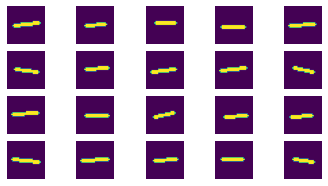

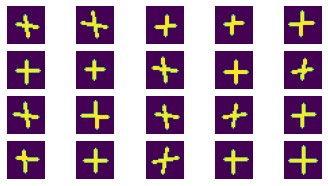

In [ ]:
# Create plus/minus signs
def generate_images(cross=False, n=50):
    x = np.random.randint(12, 16, (n, 2)) #random generate integer arrays between 12 and 16 with shape (50,2)
    y1 = np.random.randint(4, 8, n) #random generate n = 50 intergers between 4 and 8 
    y2 = np.random.randint(20, 24, n) #random generate n = 50 intergers between 20 and 24
    
    blank = np.zeros([n, 28, 28]) #generate zero arrays with shape (50, 28, 28), 50 arrays with shape (28,28), which is the size of MNIST 
    for i in range(n):
        line = cv2.line(blank[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA) #draw lines in each "blank" array, start coordinates(left side),
        #end coordinates(right side) to make horizontal lines, gray colors, line thickness 2 px, line type
        if cross:
            line = cv2.line(blank[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) #if cross true, draw vertical lines with opposite
            #coordinates to the horizontal lines, and stack on horizontal lines to make crosses

    return blank

def show_generated(images):
    for i in range(20):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(cross=True))

In [ ]:
np.random.randint(12, 16, (50, 2))[0,0]

#np.zeros([50, 28, 28]).shape

12

In [ ]:
import random

def create_data(highest_integer):
    """
    Creates the following data for all pairs of integers up to [highest integer]+[highest_integer]:

    @return:
    X_text: '151+ 21' -> text query of an arithmetic operation
    X_img : Stack of MNIST images corresponding to the query (7 x 28 x 28)  #two numbers stack together with a sign
    y_text: ' 172' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (4 x 28 x 28) #one number with a sign

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]  #indices of digits
    num_data = [MNIST_data[inds] for inds in num_indices]  #digits in the dataset
    image_mapping = dict(zip(unique_characters[:10], num_data)) 
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(cross=True)
    image_mapping[' '] = np.zeros([1, 28, 28]) #map each integer and sign to its respective arrays
    #print(image_mapping)

    X_text, X_img, y_text, y_img = [], [], [], []
    for i in range(highest_integer + 1): #highest_integer = 199, thus range(199 + 1)
        for j in range(highest_integer + 1):
            
            i_char = to_padded_chars(i, max_len=max_int_length) #add a space to each integer, which makes each integer the same length
            j_char = to_padded_chars(j, max_len=max_int_length)

            for sign in ['-', '+']:
                query_string = i_char + sign + j_char 
                #print(query_string)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char] #map each integer and sign to its respective image arrays
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze()) #flatten each unique array

                result = eval(query_string) #the value of y_text, eval() evaluates string expressions
                result_string = to_padded_chars(result, max_len=max_answer_length) #make y_text to length = 4
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze()) #create y_img for result numbers

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))
            
    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.
  
def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


In [ ]:
to_padded_chars(199, max_len=3)

#for n, char in enumerate(to_padded_chars(199, max_len=3)):
  #print(char)


#eval("199 - 2")

'199'

# Creating our data

The dataset consists of 80000 samples that have two kinds of inputs and labels:

  X_text: strings containing queries of length 7: ['  1+  1', '174- 18', ...] 

  X_image: a stack of images representing a single query, dimensions: [7, 28, 28]

  y_text: strings containing answers of length 4: ['   2', ' 156']

  y_image: a stack of images that represents the answer to a query, dimensions: [4, 28, 28]

(80000,) (80000, 7, 28, 28) (80000,) (80000, 4, 28, 28)
Sample ID: 41688

X_text: "104- 44" = y_text: "  60"


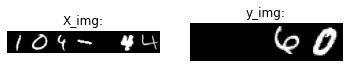

Sample ID: 79895

X_text: "199+147" = y_text: " 346"


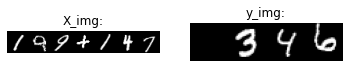

Sample ID: 33592

X_text: " 83-196" = y_text: "-113"


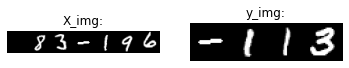

Sample ID: 15800

X_text: " 39-100" = y_text: " -61"


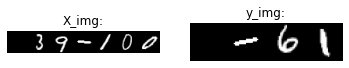

Sample ID: 48071

X_text: "120+ 35" = y_text: " 155"


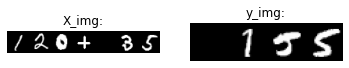

Sample ID: 55355

X_text: "138+ 77" = y_text: " 215"


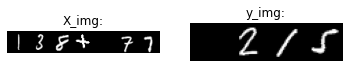

Sample ID: 59924

X_text: "149-162" = y_text: " -13"


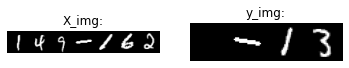

Sample ID: 2282

X_text: "  5-141" = y_text: "-136"


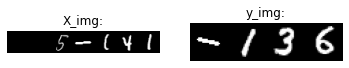

Sample ID: 59914

X_text: "149-157" = y_text: "  -8"


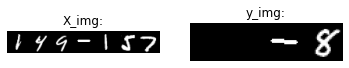

Sample ID: 19413

X_text: " 48+106" = y_text: " 154"


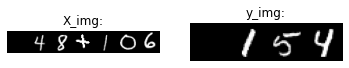

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- ' # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 199 # Highest value of integers contained in the queries
max_int_length = len(str(highest_integer)) #max_int_length = 3
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10']) : "7"
max_answer_length = max_int_length + 1    # Maximum length of the answer string :  "4"

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer) #highest_integer = 199
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labs = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        #print(i, data)
        plt.subplot(1,2,i+1)
        plt.axis('off')
        plt.title(labs[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nSample ID: {n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 80000, 1)[0])

In [ ]:
#np.random.randint(0, 80000, 1)[0]
#len([X_img, y_img])

#li = [[1, 2, 3, 4],[5, 6, 7, 8]]

#for ii, dd in enumerate([[1, 2, 3, 4],[5, 6, 7, 8]]):
  #print(dd[2])
  
#len(li)

print(MNIST_data.shape)
#print(MNIST_data[0])
#print(X_img[0][2])


[np.where(MNIST_labels==x) for x in range(10)]

#MNIST_labels.shape

(60000, 28, 28)


[(array([    1,    21,    34, ..., 59952, 59972, 59987]),),
 (array([    3,     6,     8, ..., 59979, 59984, 59994]),),
 (array([    5,    16,    25, ..., 59983, 59985, 59991]),),
 (array([    7,    10,    12, ..., 59978, 59980, 59996]),),
 (array([    2,     9,    20, ..., 59943, 59951, 59975]),),
 (array([    0,    11,    35, ..., 59968, 59993, 59997]),),
 (array([   13,    18,    32, ..., 59982, 59986, 59998]),),
 (array([   15,    29,    38, ..., 59963, 59977, 59988]),),
 (array([   17,    31,    41, ..., 59989, 59995, 59999]),),
 (array([    4,    19,    22, ..., 59973, 59990, 59992]),)]

In [ ]:
#dict(zip(unique_characters[:10], MNIST_data[0]))

In [ ]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=4):
    n = len(labels) #the number of labels
    length = len(labels[0]) #the length of each label, which is 4
    char_map = dict(zip(unique_characters, range(len(unique_characters)))) #index each unique character, fix its position in the sequence
    one_hot = np.zeros([n, length, len(unique_characters)]) #n = number of lables,  number of characters of the label, all unique characters
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)]) #matrix made from label characters 
        for j, char in enumerate(label): #index and character in a label
            m[j, char_map[char]] = 1  #retrive each character in the lable to its original position in the unique characters sequence, set the character to 1
            #char is key in char_map dictionary 
        one_hot[i] = m  #encoded labels as each character is in its original position in unique character sequence

    return one_hot 

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])
    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(80000, 7, 13) (80000, 4, 13)


In [ ]:
#dict(zip(unique_characters, range(len(unique_characters))))
decode_labels(y_text_onehot[0])

'   0'

In [ ]:
dict(zip(unique_characters, range(len(unique_characters))))

{' ': 12,
 '+': 10,
 '-': 11,
 '0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [ ]:
np.zeros([5, 7, len(unique_characters)]).shape

(5, 7, 13)

---
---

# 1. Text-to-text RNN model

The following code showcases how Recurrent neural networks are built using Keras. Several new layers are going to be used:

1. LSTM 
2. TimeDistributed
3. RepeatVector

The following code shows the basic architecture of a Recurrent Neural Network
LSTM (Long Short Term Memory) layers can be replaced either with SimpleRNN or GRU (Gated Recurrent Units).



<img src="https://miro.medium.com/max/1400/1*1JcHGUU7rFgtXC_mydUA_Q.jpeg" width="500"> 


In [ ]:
# We start by initializing a sequential model
text2text = tf.keras.Sequential()

# "Encode" the input sequence using an RNN, producing an output of size 256.
# In this case the size of our input vectors is [7, 13] as we have queries of length 7 and 13 unique characters. Each of these 7 elements in the query will be fed to the network one by one,
# as shown in the image above (except with 7 elements).
# Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
text2text.add(LSTM(256, input_shape=(max_query_length, len(unique_characters))))

# As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 4 times as that's the maximum length of the output (e.g. '  1-199' = '-198')
# when using 3-digit integers in queries. In other words, the RNN will always produce 4 characters as its output.
text2text.add(RepeatVector(max_answer_length))

# By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
# the first dimension to be the timesteps.
text2text.add(LSTM(128, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
#text2text.add(TimeDistributed(Dense(max_answer_length, activation='softmax')))

# Next we compile the model using categorical crossentropy as our loss function.
text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
text2text.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               276480    
                                                                 
 repeat_vector (RepeatVector  (None, 4, 256)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 4, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 4, 13)            1677      
 ibuted)                                                         
                                                                 
Total params: 475,277
Trainable params: 475,277
Non-trainable params: 0
_________________________________________________________________


### Your tasks:


In [ ]:
# Train and experiment with the text-to-text RNN Model by using X_text and y_text as your inputs/outputs
# 1. Try different ratios of train/test splits
# 2. Try to find more optimal architectures




In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_text_onehot, y_text_onehot, test_size=0.9, 
                                                random_state = 2, shuffle = True)


In [ ]:
print(Xtrain.shape)
print(ytrain.shape)

(8000, 7, 13)
(8000, 4, 13)


In [ ]:
t2t_history = text2text.fit(Xtrain, ytrain, epochs= 200, batch_size= 80)

Epoch 1/200
100/100 [==============================] - 7s 5ms/step - loss: 1.7977 - accuracy: 0.3705
Epoch 2/200
100/100 [==============================] - 1s 5ms/step - loss: 1.4627 - accuracy: 0.4250
Epoch 3/200
100/100 [==============================] - 1s 5ms/step - loss: 1.3813 - accuracy: 0.4579
Epoch 4/200
100/100 [==============================] - 1s 5ms/step - loss: 1.3160 - accuracy: 0.4868
Epoch 5/200
100/100 [==============================] - 1s 5ms/step - loss: 1.2577 - accuracy: 0.5114
Epoch 6/200
100/100 [==============================] - 1s 5ms/step - loss: 1.2094 - accuracy: 0.5312
Epoch 7/200
100/100 [==============================] - 1s 5ms/step - loss: 1.1749 - accuracy: 0.5466
Epoch 8/200
100/100 [==============================] - 1s 5ms/step - loss: 1.1534 - accuracy: 0.5555
Epoch 9/200
100/100 [==============================] - 1s 5ms/step - loss: 1.1276 - accuracy: 0.5665
Epoch 10/200
100/100 [==============================] - 1s 5ms/step - loss: 1.0985 - accura

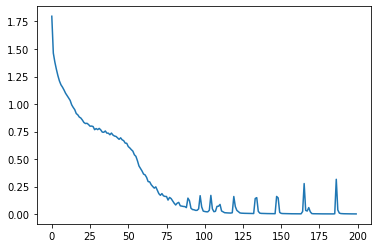

In [ ]:
plt.plot(t2t_history.history["loss"])

In [ ]:
text2text.evaluate(Xtest, ytest)

2250/2250 [==============================] - 7s 3ms/step - loss: 0.0112 - accuracy: 0.9971


[0.011231532320380211, 0.9971354007720947]

In [ ]:
ypred_raw = text2text.predict(Xtest)


In [ ]:
ypred_raw.shape

predLabels_1 = []
for row in ypred_raw:
  predLabels_1.append(decode_labels(row))
print(predLabels_1)

trueLabels_1 = []
for row in ytest:
  trueLabels_1.append(decode_labels(row))
print(trueLabels_1)

#np.argmax(ypred_raw, axis = 1)
#[unique_characters[i] for i in np.argmax(ypred_raw, axis = 1)[0]]

['  87', ' -55', ' -75', ' -99', ' -79', ' 150', ' -85', ' -63', '  21', ' -33', '  51', ' 379', '  65', ' 131', '  37', ' 135', ' -31', '  51', ' 186', ' 167', ' 190', '  13', ' -19', '  15', '  30', ' -95', '  26', ' 158', ' -69', ' 192', ' -38', '  35', ' -86', ' 123', ' 315', ' 185', '  -9', ' 206', ' 175', ' 153', '  22', ' 144', '  70', '  44', '  39', '  -2', ' -80', ' 218', '  64', ' 164', ' 201', '-176', ' 103', ' 224', ' 248', ' 254', '  86', '  70', '  81', '-100', '  -3', ' 178', ' -17', ' -49', ' -40', '  71', ' 279', ' 305', '  45', ' -74', '  87', ' 154', ' 107', '  78', ' 202', ' -10', '  91', ' -92', ' -78', '-150', ' 125', ' -64', '  67', '  96', '  20', '  16', ' -73', ' 247', ' 338', ' 147', ' 299', ' 235', ' 204', ' -44', '  79', ' -10', ' 102', ' 223', ' -17', ' 308', '  -3', ' 261', '  84', ' 304', ' 204', ' -25', '  -4', ' 170', ' 117', ' 187', ' 237', ' 276', ' 297', ' -75', ' -53', ' 142', ' -52', '   2', ' 252', ' 266', '  59', ' -14', ' 270', ' 215', '  68',

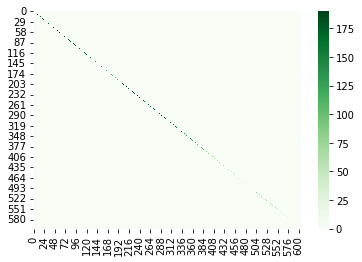

In [ ]:


confu_mat_1 = confusion_matrix(trueLabels_1, predLabels_1)

sns.heatmap(confu_mat_1, cmap="Greens") #accuracy = 0.9971,  test_size = 0.9

### test_size = 0.95,  train_size = 0.05

In [ ]:
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X_text_onehot, y_text_onehot, test_size=0.95, 
                                                shuffle = True)

In [ ]:
print(Xtrain2.shape)
print(ytrain2.shape)

(4000, 7, 13)
(4000, 4, 13)


In [ ]:
t2t_history2 = text2text.fit(Xtrain, ytrain, epochs= 150, batch_size= 80)

Epoch 1/150
200/200 [==============================] - 3s 4ms/step - loss: 1.6855 - accuracy: 0.3787
Epoch 2/150
200/200 [==============================] - 1s 4ms/step - loss: 1.4283 - accuracy: 0.4406
Epoch 3/150
200/200 [==============================] - 1s 5ms/step - loss: 1.3273 - accuracy: 0.4764
Epoch 4/150
200/200 [==============================] - 1s 4ms/step - loss: 1.2580 - accuracy: 0.5092
Epoch 5/150
200/200 [==============================] - 1s 4ms/step - loss: 1.1931 - accuracy: 0.5383
Epoch 6/150
200/200 [==============================] - 1s 4ms/step - loss: 1.1439 - accuracy: 0.5567
Epoch 7/150
200/200 [==============================] - 1s 4ms/step - loss: 1.1007 - accuracy: 0.5752
Epoch 8/150
200/200 [==============================] - 1s 4ms/step - loss: 1.0624 - accuracy: 0.5909
Epoch 9/150
200/200 [==============================] - 1s 4ms/step - loss: 1.0116 - accuracy: 0.6104
Epoch 10/150
200/200 [==============================] - 1s 4ms/step - loss: 0.9658 - accura

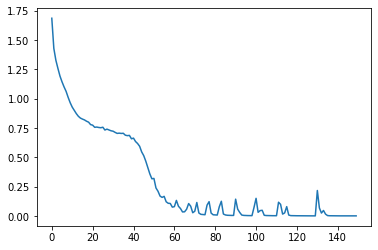

In [ ]:
plt.plot(t2t_history2.history["loss"])

In [ ]:
text2text.evaluate(Xtest2, ytest2)

2375/2375 [==============================] - 7s 3ms/step - loss: 0.0510 - accuracy: 0.9875


[0.05095427855849266, 0.9874901175498962]

In [ ]:
ypred_raw2 = text2text.predict(Xtest2)

In [ ]:
predLabels_2 = []
for row in ypred_raw2:
  predLabels_2.append(decode_labels(row))
print(predLabels_2)

trueLabels_2 = []
for row in ytest2:
  trueLabels_2.append(decode_labels(row))
print(trueLabels_2)

[' 319', ' 186', '   0', '-118', '  68', '  87', ' -15', ' 242', '  -1', ' 184', '  65', ' 181', ' 253', ' 222', '  43', ' -85', ' 149', '   3', ' 190', '  79', '  -2', ' 348', ' 261', ' 238', ' -73', ' 248', ' -92', ' -23', ' 179', ' 238', ' 192', '  89', '  35', '  50', ' 103', ' 266', ' 198', ' 148', '  27', '  15', ' 170', ' 234', ' -60', ' -76', ' -61', ' -98', '  15', ' 290', ' -23', '   4', '  56', ' 289', ' 209', ' 144', '  46', ' 166', ' 336', ' 112', ' 178', ' 249', ' -98', '  46', '  96', ' 202', ' 108', '  34', '-156', ' 226', '  93', ' -30', ' 190', ' -47', ' -99', '  68', ' 186', ' 177', ' 270', '  41', '  11', ' 180', ' 210', ' 136', '  81', ' 227', ' 117', ' 133', ' 232', ' 139', ' 173', '-189', '  93', ' 141', ' 166', '  25', '  25', '   4', ' 261', '   7', ' 116', ' 202', '  93', ' 108', ' -52', ' 244', ' 142', ' 110', ' 338', '  -7', ' 111', ' 276', '  76', ' 181', '  66', ' 164', '  31', '  80', ' 204', ' 227', ' -13', '  95', '  20', ' 106', '  59', ' -98', ' 261',

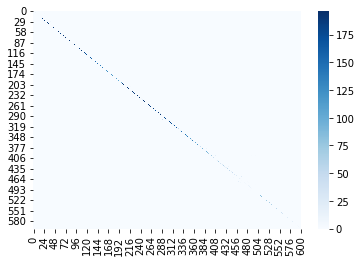

In [ ]:
confu_mat_2 = confusion_matrix(trueLabels_2, predLabels_2)
sns.heatmap(confu_mat_2, cmap = "Blues") #accuracy = 0.9875, test_size = 0.95, train_size = 0.05

In [ ]:
# We start by initializing a sequential model
text2text_1 = tf.keras.Sequential()

# "Encode" the input sequence using an RNN, producing an output of size 256.
# In this case the size of our input vectors is [7, 13] as we have queries of length 7 and 13 unique characters. Each of these 7 elements in the query will be fed to the network one by one,
# as shown in the image above (except with 7 elements).
# Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
text2text_1.add(LSTM(256, input_shape=(max_query_length, len(unique_characters))))

# As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 4 times as that's the maximum length of the output (e.g. '  1-199' = '-198')
# when using 3-digit integers in queries. In other words, the RNN will always produce 4 characters as its output.
text2text_1.add(RepeatVector(max_answer_length))

# By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
# the first dimension to be the timesteps.
text2text_1.add(LSTM(128, return_sequences=True))
#text2text_1.add(SimpleRNN(128, return_sequences=True))
text2text_1.add(GRU(128, return_sequences=True))


# Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
text2text_1.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
#text2text.add(TimeDistributed(Dense(max_answer_length, activation='softmax')))

# Next we compile the model using categorical crossentropy as our loss function.
text2text_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
text2text_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               276480    
                                                                 
 repeat_vector_1 (RepeatVect  (None, 4, 256)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 4, 128)            197120    
                                                                 
 gru (GRU)                   (None, 4, 128)            99072     
                                                                 
 time_distributed_1 (TimeDis  (None, 4, 13)            1677      
 tributed)                                                       
                                                                 
Total params: 574,349
Trainable params: 574,349
Non-tr

In [ ]:
Xtrain3, Xtest3, ytrain3, ytest3 = train_test_split(X_text_onehot, y_text_onehot, test_size=0.9, 
                                                shuffle = True, random_state = 1)

In [ ]:
print(Xtrain3.shape)
print(ytrain3.shape)

(8000, 7, 13)
(8000, 4, 13)


In [ ]:
t2t_history3 = text2text_1.fit(Xtrain3, ytrain3, batch_size=80, epochs=120)

Epoch 1/120
100/100 [==============================] - 4s 7ms/step - loss: 1.8090 - accuracy: 0.3573
Epoch 2/120
100/100 [==============================] - 1s 6ms/step - loss: 1.5202 - accuracy: 0.4045
Epoch 3/120
100/100 [==============================] - 1s 7ms/step - loss: 1.4452 - accuracy: 0.4292
Epoch 4/120
100/100 [==============================] - 1s 7ms/step - loss: 1.3923 - accuracy: 0.4513
Epoch 5/120
100/100 [==============================] - 1s 7ms/step - loss: 1.3137 - accuracy: 0.4813
Epoch 6/120
100/100 [==============================] - 1s 7ms/step - loss: 1.2602 - accuracy: 0.4972
Epoch 7/120
100/100 [==============================] - 1s 7ms/step - loss: 1.2161 - accuracy: 0.5209
Epoch 8/120
100/100 [==============================] - 1s 7ms/step - loss: 1.1737 - accuracy: 0.5428
Epoch 9/120
100/100 [==============================] - 1s 7ms/step - loss: 1.1345 - accuracy: 0.5609
Epoch 10/120
100/100 [==============================] - 1s 7ms/step - loss: 1.0936 - accura

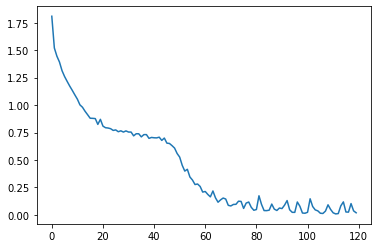

In [ ]:
plt.plot(t2t_history3.history["loss"])

In [ ]:
text2text_1.evaluate(Xtest3, ytest3)
# more training samples lead to better results (higher accuracy)  SimpleRNN accuracy 0.9958
                                                                  #GRU accuracy = 0.9903

2250/2250 [==============================] - 8s 3ms/step - loss: 0.0341 - accuracy: 0.9903


[0.0341133177280426, 0.9903125166893005]


---
---

# 2. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use X_img as inputs and y_text as outputs.

In [ ]:
print(X_text.shape)
print(X_text_onehot.shape)
print(y_text.shape)
print(y_text_onehot.shape)
print(X_img.shape)
print(y_img.shape)

(80000,)
(80000, 7, 13)
(80000,)
(80000, 4, 13)
(80000, 7, 28, 28)
(80000, 4, 28, 28)


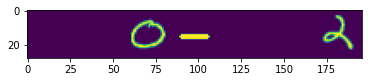

In [ ]:
plt.imshow(np.hstack(X_img[4]))
plt.show()

In [ ]:
print(np.hstack(X_img[0]).shape)

(28, 196)


In [ ]:
# Your code

image2text = tf.keras.Sequential()
in_shape = (7,28,28,1)


image2text.add(ConvLSTM2D(filters= 32, kernel_size= (5,5), padding="same", input_shape= in_shape, return_sequences=True))
image2text.add(MaxPool3D(pool_size=(1,2,2)))
image2text.add(BatchNormalization())

image2text.add(ConvLSTM2D(filters= 32, kernel_size= (5,5), padding="same", return_sequences=True))
image2text.add(MaxPool3D(pool_size=(1,2,2)))
image2text.add(BatchNormalization())

image2text.add(ConvLSTM2D(filters= 64, kernel_size= (3,3), padding="same", return_sequences=True))
image2text.add(MaxPool3D(pool_size=(1,2,2)))
image2text.add(BatchNormalization())
#image2text.add(Dropout(0.25))

image2text.add(ConvLSTM2D(filters= 64, kernel_size= (3,3), padding="same", return_sequences=True))
image2text.add(MaxPool3D(pool_size=(1,2,2)))
image2text.add(BatchNormalization())
#image2text.add(Dropout(0.25))

image2text.add(Flatten())


# As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 4 times as that's the maximum length of the output (e.g. '  1-199' = '-198')
# when using 3-digit integers in queries. In other words, the RNN will always produce 4 characters as its output
image2text.add(RepeatVector(max_answer_length))

# By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
# the first dimension to be the timesteps.

#image2text.add(LSTM(512, return_sequences=True))
#image2text.add(Dropout(0.5))
image2text.add(LSTM(256, return_sequences=True))
image2text.add(Dropout(0.5))



# Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
image2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))


# Next we compile the model using categorical crossentropy as our loss function.
image2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
image2text.summary()





Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_66 (ConvLSTM2D)  (None, 7, 28, 28, 32)    105728    
                                                                 
 max_pooling3d_63 (MaxPoolin  (None, 7, 14, 14, 32)    0         
 g3D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 7, 14, 14, 32)    128       
 ormalization)                                                   
                                                                 
 conv_lstm2d_67 (ConvLSTM2D)  (None, 7, 14, 14, 32)    204928    
                                                                 
 max_pooling3d_64 (MaxPoolin  (None, 7, 7, 7, 32)      0         
 g3D)                                                            
                                                     

In [ ]:
X_img_new = np.expand_dims(X_img, axis= -1)
print(X_img_new.shape)
y_img_new = np.expand_dims(y_img, axis = -1)
print(y_img_new.shape)

(80000, 7, 28, 28, 1)
(80000, 4, 28, 28, 1)


In [ ]:
Ximg_train, Ximg_test, ytx_train, ytx_test = train_test_split(X_img_new, y_text_onehot, test_size = 0.8,
                                                              shuffle = True)

In [ ]:
#print(Ximg_train)
print(Ximg_train.shape)
print(ytx_train.shape)

(16000, 7, 28, 28, 1)
(16000, 4, 13)


In [ ]:
img2t_history = image2text.fit(Ximg_train, ytx_train, batch_size=100, epochs=120)

Epoch 1/120
160/160 [==============================] - 39s 195ms/step - loss: 1.6140 - accuracy: 0.4012
Epoch 2/120
160/160 [==============================] - 31s 194ms/step - loss: 1.3736 - accuracy: 0.4592
Epoch 3/120
160/160 [==============================] - 31s 195ms/step - loss: 1.3102 - accuracy: 0.4870
Epoch 4/120
160/160 [==============================] - 31s 194ms/step - loss: 1.2606 - accuracy: 0.5112
Epoch 5/120
160/160 [==============================] - 31s 194ms/step - loss: 1.2189 - accuracy: 0.5291
Epoch 6/120
160/160 [==============================] - 31s 193ms/step - loss: 1.1706 - accuracy: 0.5480
Epoch 7/120
160/160 [==============================] - 31s 193ms/step - loss: 1.1135 - accuracy: 0.5694
Epoch 8/120
160/160 [==============================] - 31s 193ms/step - loss: 1.0525 - accuracy: 0.5914
Epoch 9/120
160/160 [==============================] - 31s 194ms/step - loss: 1.0066 - accuracy: 0.6074
Epoch 10/120
160/160 [==============================] - 31s 194m

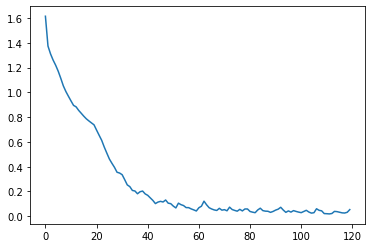

In [ ]:
plt.plot(img2t_history.history["loss"])

In [ ]:
image2text.evaluate(Ximg_test, ytx_test)

2000/2000 [==============================] - 82s 40ms/step - loss: 0.3011 - accuracy: 0.9566


[0.3010905683040619, 0.9565781354904175]

In [ ]:
tx_raw = image2text.predict(Ximg_test)

In [ ]:
predText = []
for row in tx_raw:
  predText.append(decode_labels(row))
print(predText)

trueText = []
for row in ytx_test:
  trueText.append(decode_labels(row))
print(trueText)

[' -32', '  45', ' 206', '  95', ' -50', ' 322', ' 105', '  86', ' 320', ' 269', '  76', ' -38', ' -10', ' 265', ' -30', '  95', ' -81', '  64', '-134', ' 278', ' 171', ' 215', ' 144', ' 277', '  51', ' -18', ' 194', '  97', ' -64', ' 209', '  11', '  58', '  96', ' 204', '  47', '  -8', ' 204', ' 242', ' -82', '-150', ' 266', '  98', '  60', ' -95', ' -23', ' 199', ' 186', '  58', ' 307', ' -30', ' -65', '-104', ' 244', ' -35', ' 324', ' 309', ' 123', ' -31', ' -63', ' 202', '  89', ' -38', ' 161', ' 369', ' 102', ' -78', '  15', ' 143', ' 193', ' -17', ' 304', ' 231', ' 142', ' 206', '  44', '  -3', ' 231', ' 245', ' 212', ' 217', '  12', ' 293', ' 174', ' 128', ' 164', '  15', ' 242', ' 250', '-168', ' 220', ' 125', ' 199', '  99', '  -5', '   0', '  87', ' 109', ' 355', ' 204', ' -83', ' 172', ' 345', ' 163', ' 187', ' 223', ' 351', ' -51', ' -51', '  66', ' -20', '  15', '  43', ' 104', ' 153', '  30', ' 328', ' 235', ' -81', ' -78', ' 162', '  95', '  20', ' 205', '  25', ' 128',

In [ ]:
confu_mat_img2tx = confusion_matrix(trueText, predText)

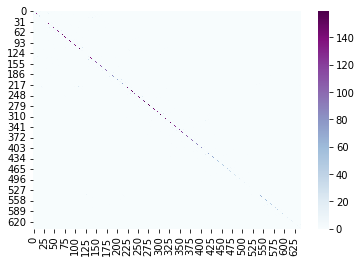

In [ ]:
sns.heatmap(confu_mat_img2tx, cmap = "BuPu") #accuracy = 0.9566,  4 layers, 1 lstm layer with 256 nodes, test_size = 0.8

---
---

# 3. Text to image RNN Model

Hint: to make this model work well you will need deconvolutional layers in your decoder (look up ***Conv2DTranspose*** layer). To connect this from a flat latent vector you will also need an operation which is opposite to a ***Flatten*** layer that you usually use in convolutional architectures - for this look up the ***Reshape*** layer.

The goal here is to use X_text as inputs and y_img as outputs.

In [ ]:
print(X_text.shape)
print(X_text_onehot.shape)
print(y_img.shape)

(80000,)
(80000, 7, 13)
(80000, 4, 28, 28)


(28, 112)


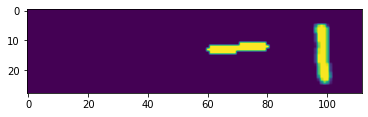

In [ ]:
print(np.hstack(y_img[2]).shape)
plt.imshow(np.hstack(y_img[2]))

In [ ]:
# Your code

text2image = tf.keras.Sequential()
# In this case the size of our input vectors is [7, 13] as we have queries of length 7 and 13 unique characters. Each of these 7 elements in the query will be fed to the network one by one,
text2image.add(LSTM(256, input_shape=(max_query_length, len(unique_characters))))
# As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 4 times as that's 
#the maximum length of the output (e.g. '  1-199' = '-198')
#text2image.add(RepeatVector(max_answer_length)) 
text2image.add(RepeatVector(28)) 
# By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
# the first dimension to be the timesteps.

text2image.add(LSTM(224, return_sequences=True))
text2image.add(LSTM(128, return_sequences=True))
text2image.add(LSTM(112, return_sequences=True))

#text2image.add(LSTM(784, return_sequences=True))

text2image.add(TimeDistributed(Dense(112, activation="relu")))

#text2image.add(Dense(784, activation="relu"))

#text2image.add(Reshape(target_shape=(4,28,28,1)))

text2image.add(Reshape(target_shape=(28,112,1)))

text2image.add(Conv2DTranspose(filters=64, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_uniform"))
#text2image.add(BatchNormalization())

text2image.add(Conv2DTranspose(filters=64, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_uniform"))
#text2image.add(BatchNormalization())

text2image.add(Conv2DTranspose(filters=32, kernel_size=5, padding="same", activation="relu", kernel_initializer="he_uniform"))
#text2image.add(BatchNormalization())

text2image.add(Conv2DTranspose(filters=32, kernel_size=5, padding="same", activation="relu", kernel_initializer="he_uniform"))
#text2image.add(BatchNormalization())

text2image.add(Conv2DTranspose(filters=1, kernel_size=5, padding="same", activation="sigmoid"))




# Next we compile the model using categorical crossentropy as our loss function.
text2image.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
text2image.summary()




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 256)               276480    
                                                                 
 repeat_vector_6 (RepeatVect  (None, 28, 256)          0         
 or)                                                             
                                                                 
 lstm_18 (LSTM)              (None, 28, 224)           430976    
                                                                 
 lstm_19 (LSTM)              (None, 28, 128)           180736    
                                                                 
 lstm_20 (LSTM)              (None, 28, 112)           107968    
                                                                 
 time_distributed_6 (TimeDis  (None, 28, 112)          12656     
 tributed)                                            

In [ ]:
#y_img_new = np.expand_dims(y_img, axis=-1)
#print(y_img_new.shape)

y_img_new1 = np.array([np.expand_dims(np.hstack(row), axis = -1) for row in y_img])

print(y_img_new1.shape)

(80000, 28, 112, 1)


In [ ]:
Xtext_train, Xtext_test, yimg_train, yimg_test = train_test_split(X_text_onehot, y_img_new1, test_size=0.6, 
                                                                  shuffle = True)

In [ ]:
print(Xtext_train.shape)
print(yimg_train.shape)

(40000, 7, 13)
(40000, 28, 112, 1)


In [ ]:
tx2img_history = text2image.fit(Xtext_train, yimg_train, batch_size=100, epochs=50)

Epoch 1/50
400/400 [==============================] - 22s 46ms/step - loss: 0.1984 - accuracy: 0.8661
Epoch 2/50
400/400 [==============================] - 18s 46ms/step - loss: 0.1663 - accuracy: 0.8765
Epoch 3/50
400/400 [==============================] - 18s 46ms/step - loss: 0.1635 - accuracy: 0.8768
Epoch 4/50
400/400 [==============================] - 18s 46ms/step - loss: 0.1621 - accuracy: 0.8766
Epoch 5/50
400/400 [==============================] - 18s 46ms/step - loss: 0.1612 - accuracy: 0.8766
Epoch 6/50
400/400 [==============================] - 18s 46ms/step - loss: 0.1604 - accuracy: 0.8763
Epoch 7/50
400/400 [==============================] - 18s 46ms/step - loss: 0.1599 - accuracy: 0.8761
Epoch 8/50
400/400 [==============================] - 18s 46ms/step - loss: 0.1592 - accuracy: 0.8759
Epoch 9/50
400/400 [==============================] - 18s 46ms/step - loss: 0.1585 - accuracy: 0.8759
Epoch 10/50
400/400 [==============================] - 18s 46ms/step - loss: 0.158

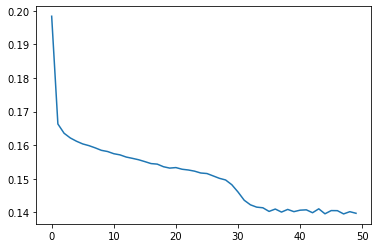

In [ ]:
plt.plot(tx2img_history.history["loss"])

In [ ]:
text2image.evaluate(Xtext_test, yimg_test)

1250/1250 [==============================] - 9s 6ms/step - loss: 0.1395 - accuracy: 0.8738


[0.13953012228012085, 0.8738118410110474]

In [ ]:
#pred_img_3d = text2image.predict(Xtext_test)

In [ ]:
#print(pred_img_3d.shape)
#pred_img_reshape = pred_img_3d.reshape(64000, 4, 28, 28)



(64000, 4, 28, 28, 1)


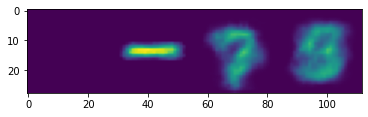

In [ ]:
#plt.imshow(np.hstack(pred_img_reshape[2]))


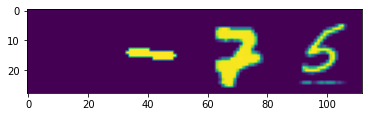

In [ ]:
#plt.imshow(np.hstack(yimg_test.reshape(64000, 4,28,28)[2]))

In [ ]:
pred_img_2d = text2image.predict(Xtext_test)

(56000, 28, 112, 1)


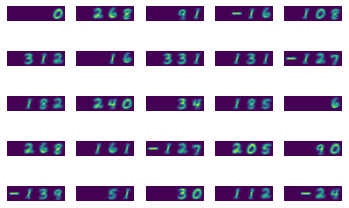

In [ ]:

for i in range(25):
  plt.subplot(5,5,i+1)
  plt.axis("off")
  plt.imshow(np.hstack(pred_img_2d[i]).T)
plt.show()

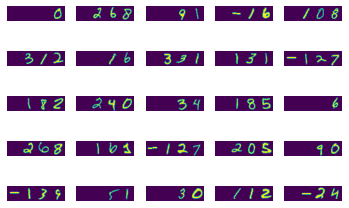

In [ ]:
for j in range(25):
  plt.subplot(5,5,j+1)
  plt.axis("off")
  plt.imshow(np.hstack(yimg_test[j]).T)
plt.show()
